In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.colors import LogNorm

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

In [188]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [2]:
pd.set_option('display.max_columns', 500)

In [525]:
singles = pd.read_pickle('data/singles.pkl')
fastn = pd.read_pickle('data/fastn_20runs.pkl')

### Clean out the non-constructed events

In [5]:
def clean_data(df):
    df_cleaned = df[df['azimuth_ks']>=0.]
    print('Initial events: %i\nAfter removing non-triggers: %i'%(len(df), len(df_cleaned)))
    return df_cleaned

In [526]:
singles = clean_data(singles)
fastn = clean_data(fastn)

Initial events: 312217
After removing non-triggers: 40469
Initial events: 1858
After removing non-triggers: 1599


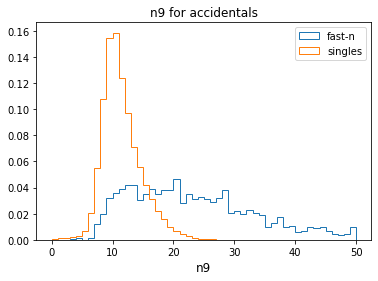

In [527]:
plt.hist(fastn['n9'], 
         label='fast-n',
         bins=np.linspace(0,50,51), 
        histtype='step', density=True, )
plt.hist(singles['n9'], 
         label='singles',
         bins=np.linspace(0,50,51), 
        histtype='step', density=True)
plt.xlabel('n9', fontsize=12)
plt.legend()
# plt.yscale('log')
plt.title('n9 for accidentals')
plt.show()

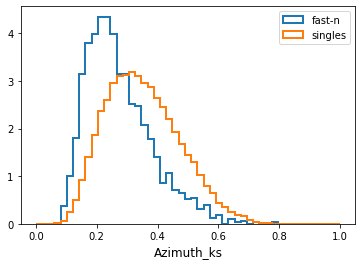

In [528]:
plt.hist(fastn['azimuth_ks'], 
         label='fast-n',
         bins=np.linspace(0,1,50), linewidth=2,
        histtype='step', density=True, )
plt.hist(singles['azimuth_ks'], 
         label='singles',
         bins=np.linspace(0,1,50), linewidth=2,
        histtype='step', density=True)
plt.xlabel('Azimuth_ks', fontsize=12)
plt.legend()
plt.show()

In [529]:
from matplotlib import cm

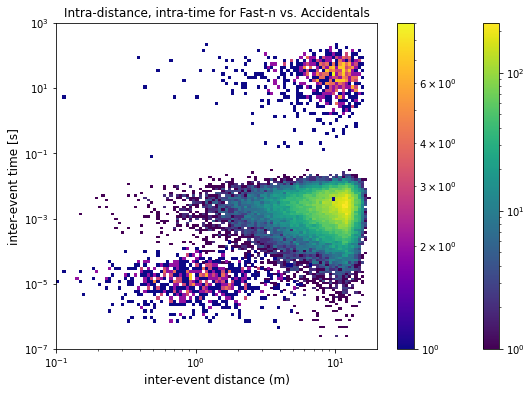

In [530]:
plt.figure(figsize=(9,6))
plt.hist2d(singles['drPrevr']/1e3, singles['dt_prev_us']/1e6, 
          bins=[np.logspace(-1,1.3,100), np.logspace(-7,0,100)], 
          cmin=1, norm=LogNorm()
          )
plt.colorbar()
plt.hist2d(fastn['drPrevr']/1e3, fastn['dt_prev_us']/1e6, 
          bins=[np.logspace(-1,1.3,100), np.logspace(-7,3,100)], 
          cmin=1, norm=LogNorm(), cmap=cm.plasma
          )
plt.colorbar()
plt.xlabel('inter-event distance (m)', fontsize=12)
plt.ylabel('inter-event time [s]', fontsize=12)
plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.title('Intra-distance, intra-time for Fast-n vs. Accidentals')
plt.show()

In [535]:
dimensions = [
    'n9', 'n9_prev',
    'x', 'y', 'z', 
    'inner_hit', 'inner_hit_prev', 
    'veto_hit', 'veto_hit_prev', 
    'good_dir', 'good_dir_prev', 
    'good_pos', 'good_pos_prev', 
    'distpmt', 
    'closestPMT', 'closestPMT_prev', #'closestPMT_next', 
    'drPrevr', 'dzPrevz',
    'dt_prev_us', 
    'azimuth_ks', 
    
]

In [536]:
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(df_cut.shape[1]))
    return df_cut

## Random Forest Classifier

In [537]:
sing = get_dims(singles).iloc[0:len(fastn)]
fast = get_dims(fastn)

Remaining variables selected for analysis: 20
Remaining variables selected for analysis: 20


In [534]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(fast)))

In [222]:
x = pd.concat([sing, fast])

In [223]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [224]:
X_save = X_test

In [225]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [278]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=20, max_depth=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [279]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 99.24%
Test Accuracy: 99.17%


In [280]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

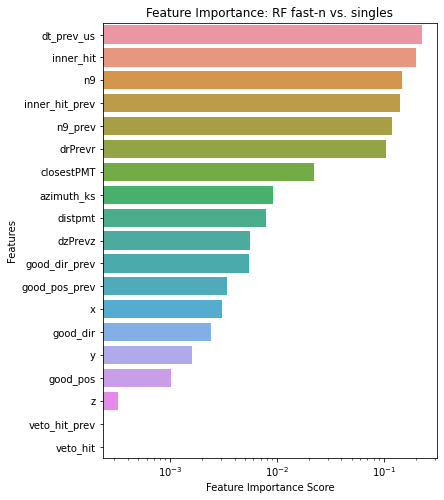

In [281]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-n vs. singles")
# plt.legend()
plt.show()

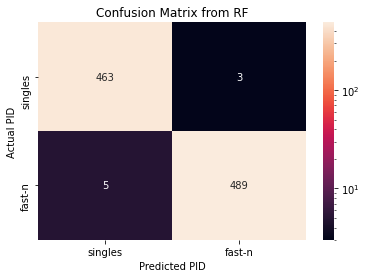

In [282]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
                 norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'fast-n'])
ax.yaxis.set_ticklabels(['singles', 'fast-n'])

plt.show()

Get the wrong predictions and see what happened 

In [184]:
wrong = X_save[y_test!=y_pred]

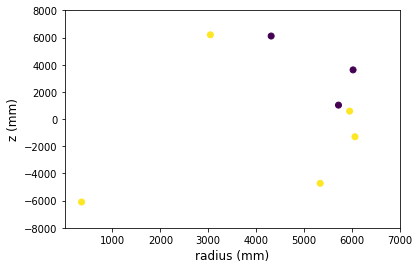

In [185]:
# plt.figure(figsize=(9,6))
plt.scatter(np.sqrt(wrong['x']**2+wrong['y']**2), 
            wrong['z'], 
            c=y_test[y_test!=y_pred], 
           )
plt.xlim(1, 7000)
plt.ylim(-8000,8000)
plt.ylabel('z (mm)', fontsize=12)
plt.xlabel('radius (mm)', fontsize=12)
plt.show()

## Linear Discriminant Analysis

In [89]:
sing = get_dims(singles).iloc[0:len(fastn)]
fast = get_dims(fastn)

Remaining variables selected for analysis: 19
Remaining variables selected for analysis: 19


In [90]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(fast)))

In [78]:
x = pd.concat([sing, fast])

In [109]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [110]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [111]:
lda = LDA(n_components=1)

In [112]:
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

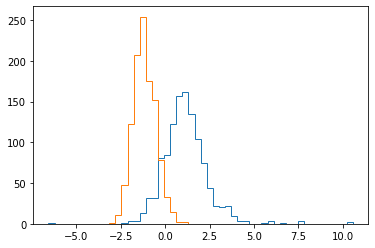

In [120]:
bins = plt.hist(X_train[y_train==1], bins=50, histtype='step')
plt.hist(X_train[y_train==0], bins=bins[1], histtype='step')
plt.show()

In [217]:
classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [218]:
confmat = metrics.confusion_matrix(y_test, y_pred)

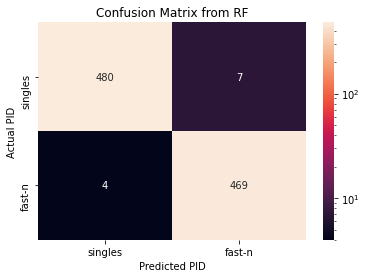

In [219]:
ax = sns.heatmap(confmat, annot=True, fmt='g', norm=LogNorm())

ax.set_title('Confusion Matrix from RF')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'fast-n'])
ax.yaxis.set_ticklabels(['singles', 'fast-n'])

plt.show()

## TSNE

In [189]:
sing = get_dims(singles).iloc[0:len(fastn)]
fast = get_dims(fastn)

Remaining variables selected for analysis: 19
Remaining variables selected for analysis: 19


In [190]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(fast)))

In [191]:
x = pd.concat([sing, fast])

In [192]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [193]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [208]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X_train)

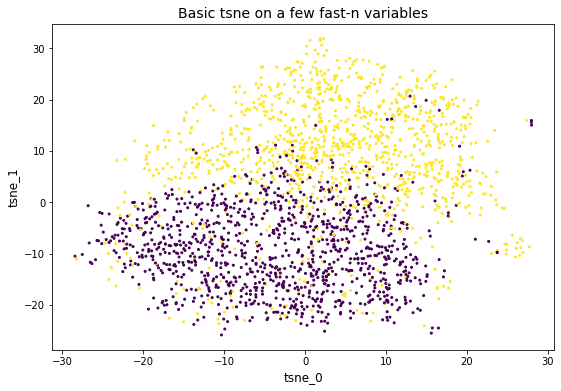

In [209]:
plt.figure(figsize=(9,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], 
           c=y_train, s=4
           )
# plt.colorbar(label='drPrevr')
plt.xlabel('tsne_0', fontsize=12)
plt.ylabel('tsne_1', fontsize=12)
plt.title('Basic tsne on a few fast-n variables', fontsize=14)
plt.show()

In [211]:
X_test_trans = tsne.fit_transform(X_test)

In [212]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_embedded, y_train)
y_pred = classifier.predict(X_embedded)

In [215]:
confmat = metrics.confusion_matrix(y_train, y_pred)

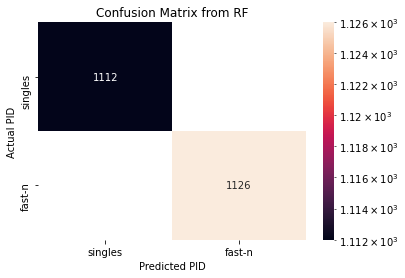

In [216]:
ax = sns.heatmap(confmat, annot=True, fmt='g', norm=LogNorm())

ax.set_title('Confusion Matrix from RF')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'fast-n'])
ax.yaxis.set_ticklabels(['singles', 'fast-n'])

plt.show()

## RF Classifier on event-by-event dimensions

In [538]:
def calcr(data):
    data['r'] = np.sqrt(data['x']**2+data['y']**2)
    return data

In [539]:
singles = calcr(singles)
fastn = calcr(fastn)

In [543]:
dimensions2 = [
    'n9', 'pe', 'n100',
    'r', 't', 
    'x', 'y', 'z', 
    'inner_hit', 
    'good_dir', 
    'good_pos', 
    'closestPMT',
    'azimuth_ks', 
    
]

In [544]:
sing = get_dims(singles, dimensions=dimensions2).iloc[0:len(fastn)]
fast = get_dims(fastn, dimensions=dimensions2)

Remaining variables selected for analysis: 13
Remaining variables selected for analysis: 13


In [545]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(fast)))

In [546]:
x = pd.concat([sing, fast])

In [547]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [548]:
X_save = X_test

In [225]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [565]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, max_depth=7)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [566]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 89.32%
Test Accuracy: 82.81%


In [567]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

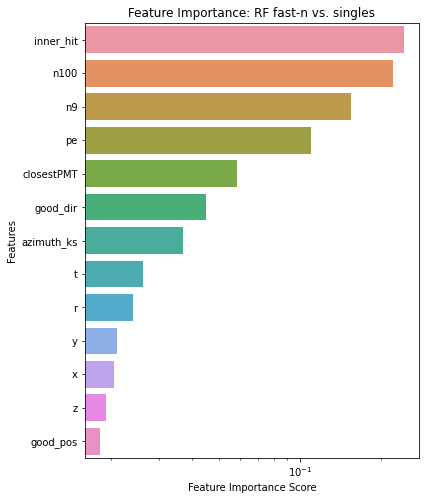

In [568]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-n vs. singles")
# plt.legend()
plt.show()

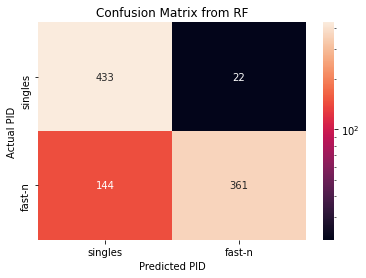

In [553]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
                 norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'fast-n'])
ax.yaxis.set_ticklabels(['singles', 'fast-n'])

plt.show()

Get the wrong predictions and see what happened 

In [556]:
wrong = X_save[y_test!=y_test_pred]

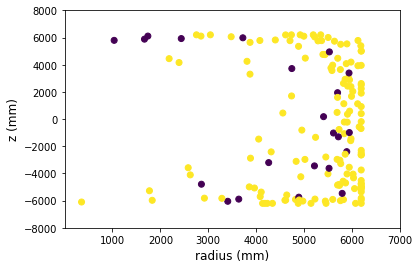

In [558]:
# plt.figure(figsize=(9,6))
plt.scatter(np.sqrt(wrong['x']**2+wrong['y']**2), 
            wrong['z'], 
            c=y_test[y_test!=y_test_pred], 
           )
plt.xlim(1, 7000)
plt.ylim(-8000,8000)
plt.ylabel('z (mm)', fontsize=12)
plt.xlabel('radius (mm)', fontsize=12)
plt.show()